In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import glob
import pathlib as pl
import salishsea_tools.geo_tools as gt

In [2]:
p1 = '/Users/arand/downloads/uas_NAM-22_ECMWF-ERAINT_evaluation_r1i1p1_CCCma-CanRCM4_r2_3hr_2007010103-2008010100.nc'
d1 = xr.open_dataset(p1)
p2 = '/Users/arand/downloads/vas_NAM-22_ECMWF-ERAINT_evaluation_r1i1p1_CCCma-CanRCM4_r2_3hr_2007010103-2008010100.nc'
d2 = xr.open_dataset(p2)


In [3]:
print(d1['uas'][472, 0, 0])
##248 - 472

<xarray.DataArray 'uas' ()>
array(-7.861711)
Coordinates:
    time     object 2007-03-01 03:00:00
    rlon     float64 -33.99
    rlat     float64 -28.71
    lon      float64 ...
    lat      float64 ...
Attributes:
    long_name:      Eastward Near-Surface Wind
    standard_name:  eastward_wind
    units:          m s-1
    cell_methods:   time:mean (interval:600 seconds)
    grid_mapping:   rotated_pole


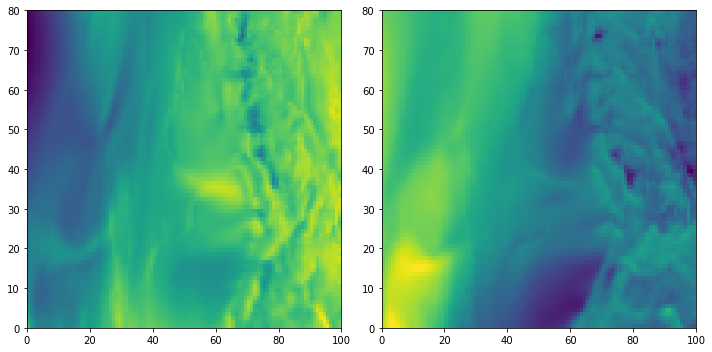

In [4]:
A = d1['uas'][247:471, 120:200, 0:100]
B = d2['vas'][247:471, 120:200, 0:100]

#plots of original data at two timestamps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(np.array(A)[0,:,:])
axs[1].pcolormesh(np.array(B)[0,:,:])
fig.tight_layout()

In [5]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr)
    data3 = np.empty((arr.shape[1]*arr.shape[2], arr.shape[0])) 
    for i in range(arr.shape[0]):
        flattened_arr = arr[i,:,:].flatten(order = 'C')
        data3[:, i] = flattened_arr[:]; 
    return data3

##reverse does the inverse of transform
def reverse(arr, arr_orig):
    a = arr_orig.shape[1]
    b = arr_orig.shape[2]
    data4 = np.empty((arr.shape[1], a, b))
    for i in range(arr.shape[1]):
        temp = arr[:,i].reshape(a,b)
        data4[i,:,:] = temp
    arr_new = arr_orig.copy(data = data4) ##copies the metadata from arr_orig, and the data from data4
    return arr_new

In [6]:
class my_PCA:
    def _init_(self, matrix, n):
        self.mat = matrix
        self.n_conp = n
        pca = PCA(n_components = n)
        self.PCs = pca.fit_transform(mat)
        self.eigvecs = pca.components_
        self.fracVar = pca.explained_variance_ratio_
        self.new_mat = pca.inverse_transform(pca.transform(mat))
    

In [7]:
A_mat = transform(A)
B_mat = transform(B)
C_mat = np.concatenate((A_mat,B_mat), axis=0) 

##conducting PCA analysis on combined data matrix
pca = PCA(n_components = 30) ##adjust the number of principle conponents to be calculated
PCs = pca.fit_transform(C_mat)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

##reconstructing data using the chosen number of principle conponents
C_new = pca.inverse_transform(pca.transform(C_mat))
split = int( C_new.shape[0]/2 )
A_new = reverse(C_new[:split,:], A) ##reconstructing u_winds from 10 PCs
B_new = reverse(C_new[split:,:], B) ##reconstructing v_winds from 10 PCs



In [8]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()

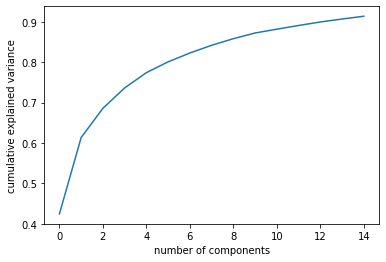

In [9]:
graph_variance(C_mat, 15)

In [10]:
print(A.shape)

(224, 80, 100)


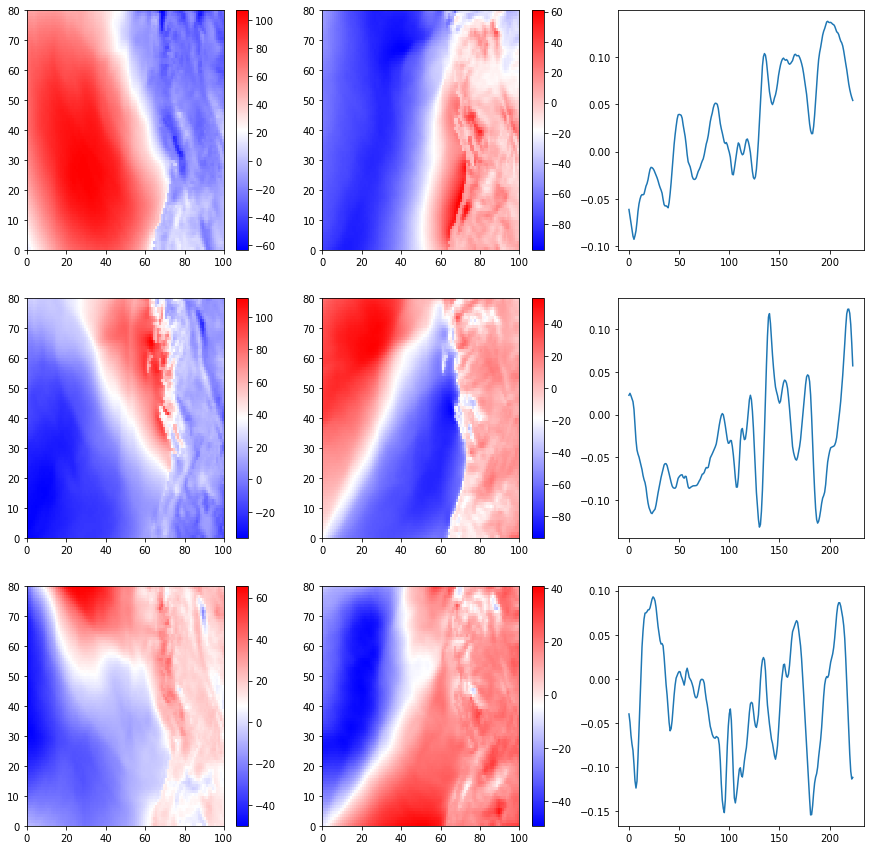

In [11]:
#displaying first 3 principle conponents (showing u_winds) and time-loading
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
mode0_u = PCs[:split, 0].reshape(A.shape[1], A.shape[2])
mode1_u = PCs[:split, 1].reshape(A.shape[1], A.shape[2])
mode2_u = PCs[:split, 2].reshape(A.shape[1], A.shape[2])
mode0_v = PCs[split:, 0].reshape(B.shape[1], B.shape[2])
mode1_v = PCs[split:, 1].reshape(B.shape[1], B.shape[2])
mode2_v = PCs[split:, 2].reshape(B.shape[1], B.shape[2])
colors = ax[0, 0].pcolormesh(mode0_u, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,0])
colors = ax[0, 1].pcolormesh(mode0_v, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,1])
ax[0, 2].plot(eigvecs[0])
colors = ax[1, 0].pcolormesh(mode1_u, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,0])
colors = ax[1, 1].pcolormesh(mode1_v, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,1])
ax[1, 2].plot(eigvecs[1])
colors = ax[2, 0].pcolormesh(mode2_u, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,0])
colors = ax[2, 1].pcolormesh(mode2_v, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,1])
ax[2, 2].plot(eigvecs[2])

In [12]:
df = pd.read_csv('/Users/arand/3h_eigvecs.csv', header = None)
arr = np.array(df)
print(arr.shape)

(10, 224)


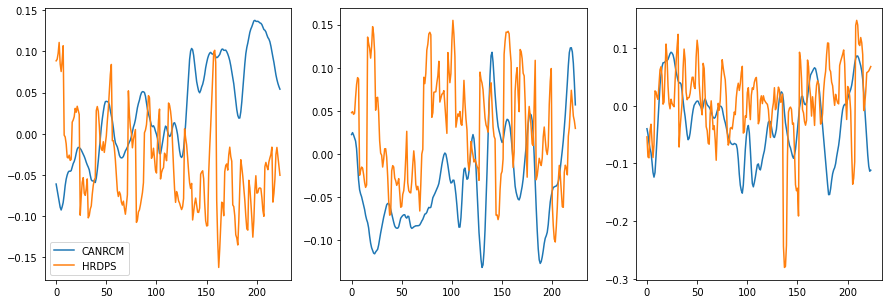

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(eigvecs[0], label = "CANRCM")
ax[1].plot(eigvecs[1], label = "CANRCM")
ax[2].plot(eigvecs[2], label = "CANRCM")

ax[0].plot(arr[0], label = "HRDPS")
ax[1].plot(arr[1], label = "HRDPS")
ax[2].plot(arr[2], label = "HRDPS")
ax[0].legend()

0.2051566354532861
0.07202049379234943
0.20353962331941944


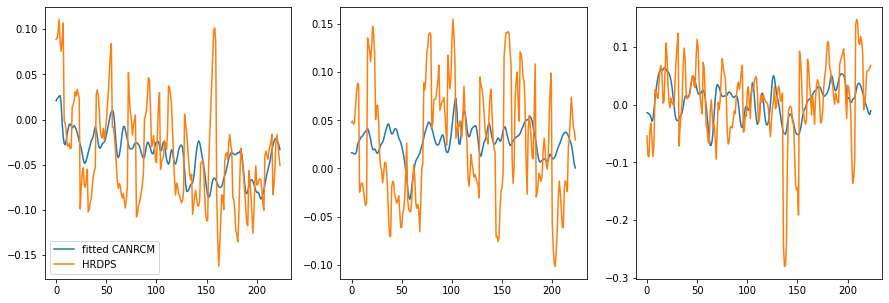

In [34]:
vec = eigvecs[0:10,:].T
reg = LinearRegression().fit(vec, arr[0,:])
fit_0 = reg.predict(vec)
print(reg.score(vec, arr[0,:]))

vec = eigvecs[0:10,:].T
reg = LinearRegression().fit(vec, arr[1,:])
fit_1 = reg.predict(vec)
print(reg.score(vec, arr[1,:]))

vec = eigvecs[0:10,:].T
reg = LinearRegression().fit(vec, arr[2,:])
fit_2 = reg.predict(vec)
print(reg.score(vec, arr[2,:]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(fit_0, label = "fitted CANRCM")
ax[1].plot(fit_1, label = "fitted CANRCM")
ax[2].plot(fit_2, label = "fitted CANRCM")

ax[0].plot(arr[0], label = "HRDPS")
ax[1].plot(arr[1], label = "HRDPS")
ax[2].plot(arr[2], label = "HRDPS")
ax[0].legend()

## PCA on Smaller Domain

In [15]:
A2 = d1['uas'][247:471,140:165,60:85]
B2 = d2['vas'][247:471,140:165,60:85]

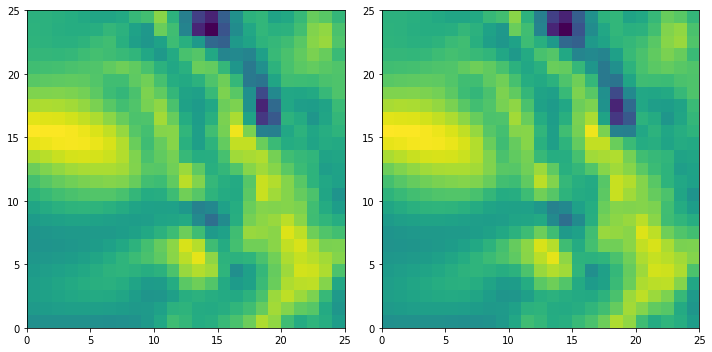

In [16]:
#plots of original data at two timestamps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(np.array(A2)[0,:,:])
axs[1].pcolormesh(np.array(A2)[0,:,:])
fig.tight_layout()

In [17]:
A_mat2 = transform(A2)
B_mat2 = transform(B2)
C_mat2 = np.concatenate((A_mat2,B_mat2), axis=0) 

##conducting PCA analysis on combined data matrix
pca2 = PCA(n_components = 30) ##adjust the number of principle conponents to be calculated
PCs2 = pca2.fit_transform(C_mat2)
eigvecs2 = pca2.components_
fracVar2 = pca2.explained_variance_ratio_

##reconstructing data using the chosen number of principle conponents
C_new2 = pca2.inverse_transform(pca2.transform(C_mat2))
split2 = int( C_new2.shape[0]/2 )
A_new2 = reverse(C_new2[:split2,:], A2) ##reconstructing u_winds from 10 PCs
B_new2 = reverse(C_new2[split2:,:], B2) ##reconstructing v_winds from 10 PCs


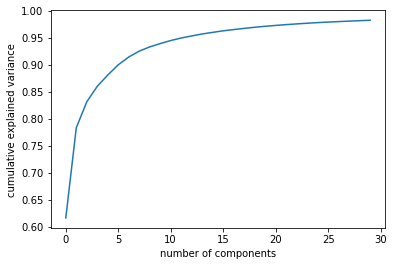

In [18]:
##graphing percentage of original data represented by the first n principle conponents

graph_variance(C_mat2, 30)

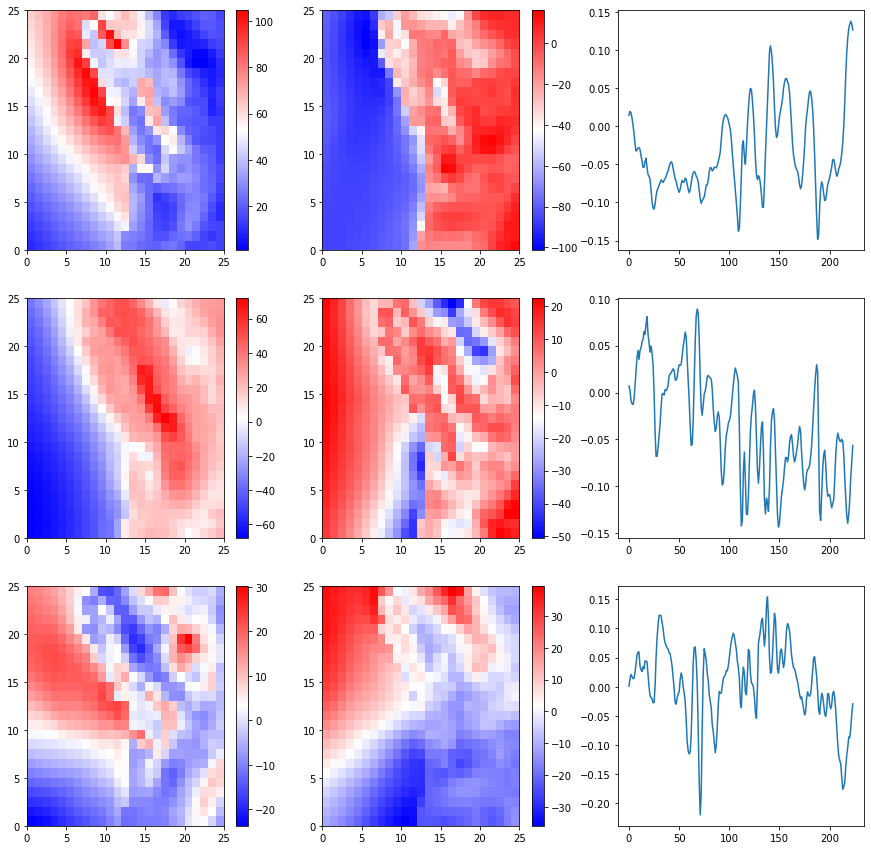

In [19]:
#displaying first 3 principle conponents (showing u_winds) and time-loading
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
mode0_u2 = PCs2[:split2, 0].reshape(A2.shape[1], A2.shape[2])
mode1_u2 = PCs2[:split2, 1].reshape(A2.shape[1], A2.shape[2])
mode2_u2 = PCs2[:split2, 2].reshape(A2.shape[1], A2.shape[2])
mode0_v2 = PCs2[split2:, 0].reshape(B2.shape[1], B2.shape[2])
mode1_v2 = PCs2[split2:, 1].reshape(B2.shape[1], B2.shape[2])
mode2_v2 = PCs2[split2:, 2].reshape(B2.shape[1], B2.shape[2])
colors = ax[0, 0].pcolormesh(mode0_u2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,0])
colors = ax[0, 1].pcolormesh(mode0_v2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,1])
ax[0, 2].plot(eigvecs2[0])
colors = ax[1, 0].pcolormesh(mode1_u2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,0])
colors = ax[1, 1].pcolormesh(mode1_v2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,1])
ax[1, 2].plot(eigvecs2[1])
colors = ax[2, 0].pcolormesh(mode2_u2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,0])
colors = ax[2, 1].pcolormesh(mode2_v2, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,1])
ax[2, 2].plot(eigvecs2[2])

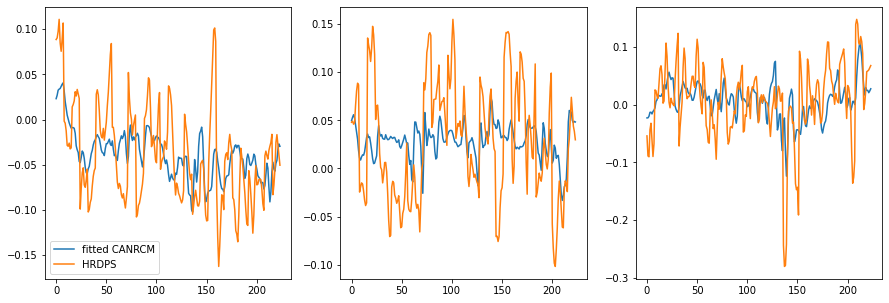

In [20]:
vec = eigvecs2[0:10,:].T
reg = LinearRegression().fit(vec, arr[0,:])
fit_0 = reg.predict(vec)

vec = eigvecs2[0:10,:].T
reg = LinearRegression().fit(vec, arr[1,:])
fit_1 = reg.predict(vec)

vec = eigvecs2[0:10,:].T
reg = LinearRegression().fit(vec, arr[2,:])
fit_2 = reg.predict(vec)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(fit_0, label = "fitted CANRCM")
ax[1].plot(fit_1, label = "fitted CANRCM")
ax[2].plot(fit_2, label = "fitted CANRCM")

ax[0].plot(arr[0], label = "HRDPS")
ax[1].plot(arr[1], label = "HRDPS")
ax[2].plot(arr[2], label = "HRDPS")
ax[0].legend()

## PCA at Mid-Scale

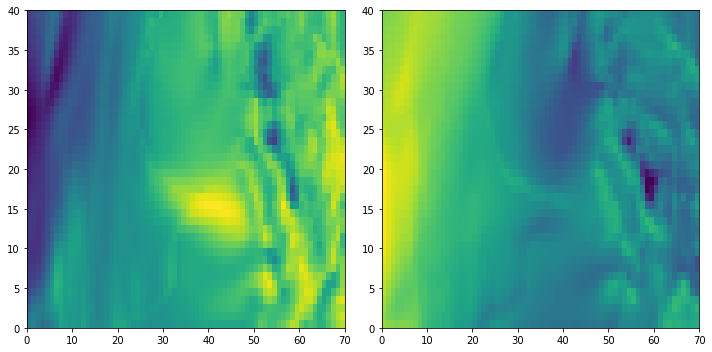

In [21]:
A3 = d1['uas'][247:471, 140:180, 20:90]
B3 = d2['vas'][247:471, 140:180, 20:90]

#plots of original data at two timestamps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(np.array(A3)[0,:,:])
axs[1].pcolormesh(np.array(B3)[0,:,:])
fig.tight_layout()

In [22]:
A_mat3 = transform(A3)
B_mat3 = transform(B3)
C_mat3 = np.concatenate((A_mat3,B_mat3), axis=0) 

##conducting PCA analysis on combined data matrix
pca3 = PCA(n_components = 30) ##adjust the number of principle conponents to be calculated
PCs3 = pca3.fit_transform(C_mat3)
eigvecs3 = pca3.components_
fracVar3 = pca3.explained_variance_ratio_

##reconstructing data using the chosen number of principle conponents
C_new3 = pca3.inverse_transform(pca3.transform(C_mat3))
split3 = int( C_new3.shape[0]/2 )
A_new3 = reverse(C_new3[:split3,:], A3) ##reconstructing u_winds from 10 PCs
B_new3 = reverse(C_new3[split3:,:], B3) ##reconstructing v_winds from 10 PCs

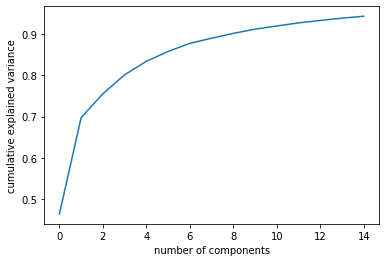

In [23]:
graph_variance(C_mat3, 15)

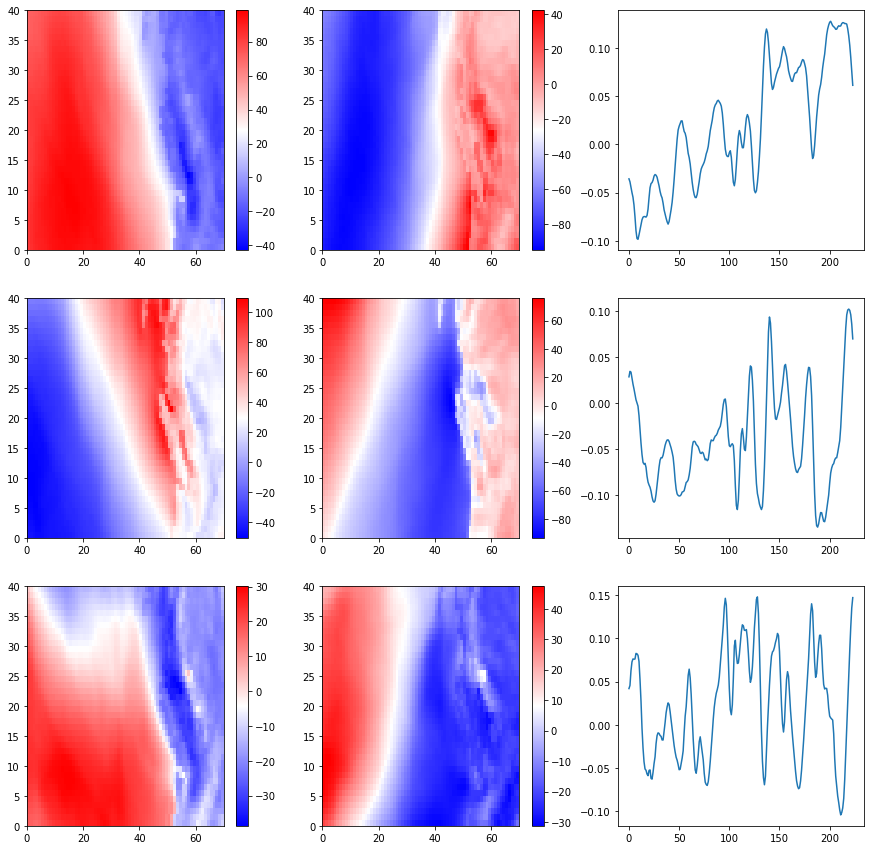

In [24]:
#displaying first 3 principle conponents (showing u_winds) and time-loading
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
mode0_u3 = PCs3[:split3, 0].reshape(A3.shape[1], A3.shape[2])
mode1_u3 = PCs3[:split3, 1].reshape(A3.shape[1], A3.shape[2])
mode2_u3 = PCs3[:split3, 2].reshape(A3.shape[1], A3.shape[2])
mode0_v3 = PCs3[split3:, 0].reshape(B3.shape[1], B3.shape[2])
mode1_v3 = PCs3[split3:, 1].reshape(B3.shape[1], B3.shape[2])
mode2_v3 = PCs3[split3:, 2].reshape(B3.shape[1], B3.shape[2])
colors = ax[0, 0].pcolormesh(mode0_u3, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,0])
colors = ax[0, 1].pcolormesh(mode0_v3, cmap = 'bwr')
fig.colorbar(colors, ax = ax[0,1])
ax[0, 2].plot(eigvecs3[0])
colors = ax[1, 0].pcolormesh(mode1_u3, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,0])
colors = ax[1, 1].pcolormesh(mode1_v3, cmap = 'bwr')
fig.colorbar(colors, ax = ax[1,1])
ax[1, 2].plot(eigvecs3[1])
colors = ax[2, 0].pcolormesh(mode2_u3, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,0])
colors = ax[2, 1].pcolormesh(mode2_v3, cmap = 'bwr')
fig.colorbar(colors, ax = ax[2,1])
ax[2, 2].plot(eigvecs3[2])

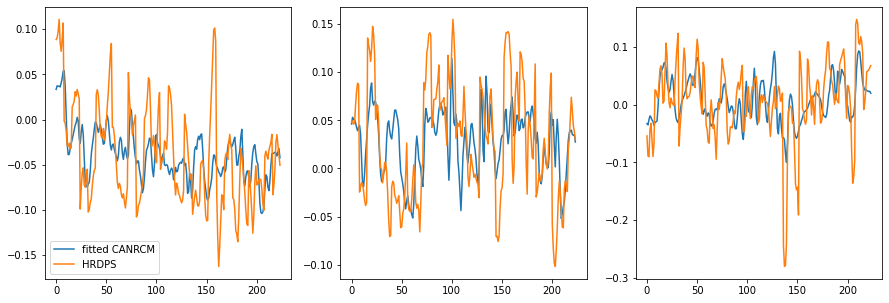

In [25]:
vec = eigvecs3[0:20,:].T
reg = LinearRegression().fit(vec, arr[0,:])
fit_0 = reg.predict(vec)

vec = eigvecs3[0:20,:].T
reg = LinearRegression().fit(vec, arr[1,:])
fit_1 = reg.predict(vec)

vec = eigvecs3[0:20,:].T
reg = LinearRegression().fit(vec, arr[2,:])
fit_2 = reg.predict(vec)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(fit_0, label = "fitted CANRCM")
ax[1].plot(fit_1, label = "fitted CANRCM")
ax[2].plot(fit_2, label = "fitted CANRCM")

ax[0].plot(arr[0], label = "HRDPS")
ax[1].plot(arr[1], label = "HRDPS")
ax[2].plot(arr[2], label = "HRDPS")
ax[0].legend()

## Looking for Correlations Between PCAs

In [35]:
def get_scores(num_scores, eigvecs, arr, row):
    scores = np.empty(num_scores)
    for i in range(num_scores):
        vec = eigvecs[0 : i+1 , :].T
        reg = LinearRegression().fit(vec, arr[row,:])
        scores[i] = reg.score(vec, arr[row,:])
    return scores

In [37]:
X = get_scores(10, eigvecs3, arr, 1)
print(X)

[2.59106601e-07 1.23473419e-02 1.48680327e-02 1.55160846e-02
 3.51205149e-02 4.01321205e-02 4.06016637e-02 4.39472231e-02
 4.69620208e-02 6.35604963e-02]


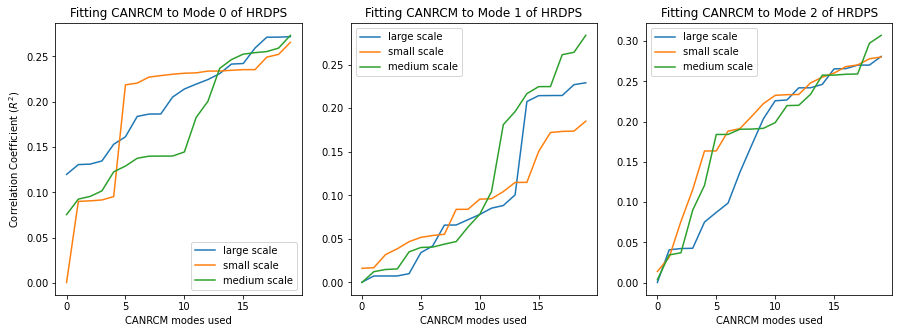

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(get_scores(20, eigvecs, arr, 0), label = "large scale")
ax[0].plot(get_scores(20, eigvecs2, arr, 0), label = "small scale")
ax[0].plot(get_scores(20, eigvecs3, arr, 0), label = "medium scale")
ax[0].set_title("Fitting CANRCM to Mode 0 of HRDPS")
ax[0].set_xlabel("CANRCM modes used")
ax[0].set_ylabel("Correlation Coefficient ($R^2$)")
ax[1].plot(get_scores(20, eigvecs, arr, 1), label = "large scale")
ax[1].plot(get_scores(20, eigvecs2, arr, 1), label = "small scale")
ax[1].plot(get_scores(20, eigvecs3, arr, 1), label = "medium scale")
ax[1].set_xlabel("CANRCM modes used")
ax[1].set_title("Fitting CANRCM to Mode 1 of HRDPS")
ax[2].plot(get_scores(20, eigvecs, arr, 2), label = "large scale")
ax[2].plot(get_scores(20, eigvecs2, arr, 2), label = "small scale")
ax[2].plot(get_scores(20, eigvecs3, arr, 2), label = "medium scale")
ax[2].set_title("Fitting CANRCM to Mode 2 of HRDPS")
ax[2].set_xlabel("CANRCM modes used")
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Comparing Wind Speeds

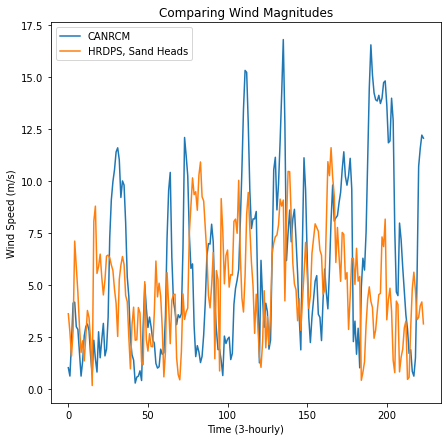

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

df = pd.read_csv('/Users/arand/winds_sh.csv', header = None)
winds_sand_heads = np.array(df)

ax.plot(np.sqrt(d1['uas'][247:471,157,74]**2 + d2['vas'][247:471,157,74]**2), label = "CANRCM")
ax.plot(winds_sand_heads, label = "HRDPS, Sand Heads")
ax.set_title("Comparing Wind Magnitudes")
ax.set_xlabel("Time (3-hourly)")
ax.set_ylabel("Wind Speed (m/s)")
ax.legend()

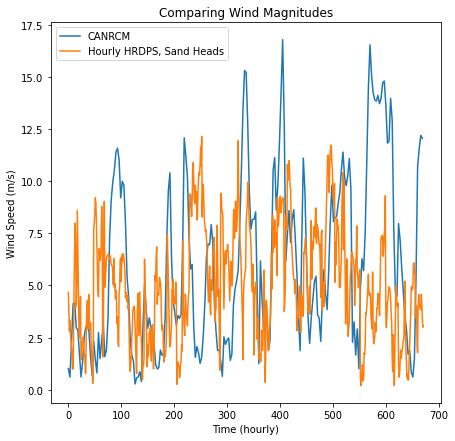

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

df = pd.read_csv('/Users/arand/winds_hourly.csv', header = None)
winds_sand_heads2 = np.array(df)

x_1 = np.array(range(28*24))
x_2 = 3*np.array(range(28*8))

ax.plot(x_2, np.sqrt(d1['uas'][247:471,157,74]**2 + d2['vas'][247:471,157,74]**2), label = "CANRCM")
ax.plot(x_1, winds_sand_heads2, label = "Hourly HRDPS, Sand Heads")
ax.set_title("Comparing Wind Magnitudes")
ax.set_xlabel("Time (hourly)")
ax.set_ylabel("Wind Speed (m/s)")
ax.legend()